In [47]:
%matplotlib inline

# Assignment 3

**DUE: Sunday November 6, 2022 11:59pm**

Turn in the assignment via Canvas.

To write legible answers you will need to be familiar with both [Markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet) and [Latex](https://www.latex-tutorial.com/tutorials/amsmath/)

Before you turn this problem in, make sure everything runs as expected. First, restart the kernel (in the menubar, select Runtime→→Restart runtime) and then run all cells (in the menubar, select Runtime→→Run All).

Make sure you fill in any place that says "YOUR CODE HERE" or "YOUR ANSWER HERE", as well as your name below:

In [48]:
NAME = "Cole Nagao"
STUDENT_ID = "1826132"

## Question 1 - Logistic Regression
---
In this question, you will build a system for predicting patient deaths in the Intensive Care Unit (ICU) using the large [PhysioNet Computing in Cardiology Challenge 2012 dataset](https://physionet.org/content/challenge-2012/1.0.0/). For each patient in the dataset, demographic variables and time series of physiological variables were collected during their stay in the ICU. 

The risk prediction system you will build could in principle be used to flag patients as being at risk of death so that physicians could intervene and improve their outcome. To be confident about the impact of such a system, you would need to run an experiment. In this question, you will use a model in order to estimate the potential impact of the system.

The data you will be working with is all available from [PhysioNet](https://physionet.org/challenge/2012/). You will be looking at only the data in "Training set A". The patient data files are [https://archive.physionet.org/challenge/2012/set-a.zip](here), and the outcomes file is [https://archive.physionet.org/challenge/2012/Outcomes-a.txt](here).





#### Downloading and Reading in the Data

First, we download the physiological data and read in patient outcomes file (links above).

We want this data to be read from text files and assembled into a dataframe. To do so, please run the following code which will first define a function that reads a text file, and then runs that function on all the files and assembles the outputs into a single dataframe.

#### Downloading the data

In [49]:
!wget https://archive.physionet.org/challenge/2012/set-a.zip -O ./set-a.zip
import zipfile
with zipfile.ZipFile('./set-a.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

--2022-11-07 04:07:49--  https://archive.physionet.org/challenge/2012/set-a.zip
Resolving archive.physionet.org (archive.physionet.org)... 128.30.30.88
Connecting to archive.physionet.org (archive.physionet.org)|128.30.30.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7938449 (7.6M) [application/zip]
Saving to: ‘./set-a.zip’

./set-a.zip         100%[===================>]   7.57M  12.7MB/s    in 0.6s    

2022-11-07 04:07:50 (12.7 MB/s) - ‘./set-a.zip’ saved [7938449/7938449]



#### Reading in data

In [50]:
import pandas as pd
import numpy as np
import glob

def comp_patient(patdat, attrs):
    patdat[patdat == -1.0] = float('NaN')
    patdat_dict = {}
    for attr in attrs:
        patdat_dict[attr] = [patdat["Value"][patdat["Parameter"]==attr].mean(axis = 0)]
    return patdat_dict


attrs = ["Age", "Gender", "Height", "Weight", "Urine", 
         "HR", "Temp", "NIDiasABP", "SysABP", "DiasABP", "pH",
         "PaCO2", "PaO2", "Platelets", "MAP", "K", "Na", "FiO2", "GCS", "RecordID"]


full_dat  = pd.DataFrame(columns = attrs)

# Now let's take the list "all_pat_dat" and assemble it into a dataframe.
filenames = sorted(glob.glob("/content/set-a/*.txt"))
for filename in filenames:
    data = open(filename)
    patient_dat_full = pd.read_csv(data, delimiter=',')
    patient_dat = pd.DataFrame.from_dict(comp_patient(patient_dat_full, attrs))
    full_dat = full_dat.append(patient_dat)

outcome_dat = pd.read_csv("https://archive.physionet.org/challenge/2012/Outcomes-a.txt")
outcome_dat[outcome_dat == -1] = float('NaN') # set all -1 to NaNs
full_dat_out = full_dat.merge(outcome_dat, left_on='RecordID', right_on='RecordID')
full_dat_out.replace([np.inf, -np.inf], np.nan)

col_means = full_dat_out.mean()


# Set everything that's NaN to the mean of that column:

# Note: we do this for simplicity. Strictly speaking, you should
# only use the training set to compute the column means

for i in range(full_dat_out.shape[1]):
    mask = np.isnan(np.array(full_dat_out.iloc[:,i]))
    full_dat_out.iloc[mask, i] = col_means[i]

full_dat_out.head()

,Age,Gender,Height,Weight,Urine,HR,Temp,NIDiasABP,SysABP,DiasABP,...,K,Na,FiO2,GCS,RecordID,SAPS-I,SOFA,Length_of_stay,Survival,In-hospital_death
0,54.0,0.0,169.787227,83.043044,171.052632,70.810811,37.357143,50.147059,118.591225,59.543420,...,4.20,136.500000,0.549199,14.923077,132539.0,6.0,1.0,5.0,351.063772,0.0
1,76.0,1.0,175.300000,80.670588,151.560976,80.794118,36.939130,56.714286,113.411765,58.897059,...,3.90,137.000000,0.560000,13.333333,132540.0,16.0,8.0,8.0,351.063772,0.0
2,44.0,0.0,169.787227,56.700000,124.951220,83.759259,37.800000,79.000000,125.687500,67.125000,...,4.26,138.333333,0.500000,5.923077,132541.0,21.0,11.0,19.0,351.063772,0.0
3,68.0,1.0,180.300000,84.600000,545.833333,70.983333,36.223077,65.051724,118.591225,59.543420,...,4.00,139.333333,0.549199,14.944444,132543.0,7.0,1.0,9.0,575.000000,0.0
4,88.0,0.0,169.787227,83.043044,62.131579,74.958333,36.880000,45.720930,118.591225,59.543420,...,4.32,139.500000,0.549199,15.000000,132545.0,17.0,2.0,4.0,918.000000,0.0


### a) Understanding the Data (2 points)
Looking at the files and the code provided above, explain:


*   What is the size of your input data? how many parameters exist in the data?
*   Exaplain what the code provided above is trying to achieve.



- There are 24 parameters per patient and 4000 patients
- The provided code takes the data from the given file and compiles all of the data into subsets such that the overall np array is compiled of patients(rows) who each have attributes(columns)

### b) Run Logistic Regression (9 points)


Divide your data into training, validation, and test sets (60-20-20). 

Use the features `HR`, `Gender`, `age`, `temperature`, `weight`, `height`, `PaO2`, and  `PaCO2`, and fit a logistic regression model to predict in-hospital death. 

In [51]:
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from tensorflow.keras.callbacks import Callback
from sklearn.linear_model import LogisticRegression, LinearRegression

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sklearn
from sklearn import datasets, linear_model, metrics
from mlxtend.plotting import plot_decision_regions

In [52]:
#Dropping all the unneeded parameters
X = full_dat_out.drop(columns=['FiO2'])
X = X.drop(columns=['Survival'])
X = X.drop(columns=['Length_of_stay'])
X = X.drop(columns=['SOFA'])
X = X.drop(columns=['SAPS-I'])
X = X.drop(columns=['RecordID'])
X = X.drop(columns=['GCS'])
X = X.drop(columns=['Urine'])
X = X.drop(columns=['NIDiasABP'])
X = X.drop(columns=['SysABP'])
X = X.drop(columns=['DiasABP'])
X = X.drop(columns=['pH'])
X = X.drop(columns=['Platelets'])
X = X.drop(columns=['K'])
X = X.drop(columns=['Na'])
X = X.drop(columns=['MAP'])

X.head()

,Age,Gender,Height,Weight,HR,Temp,PaCO2,PaO2,In-hospital_death
0,54.0,0.0,169.787227,83.043044,70.810811,37.357143,40.382018,147.987136,0.0
1,76.0,1.0,175.300000,80.670588,80.794118,36.939130,38.857143,210.142857,0.0
2,44.0,0.0,169.787227,56.700000,83.759259,37.800000,35.500000,134.500000,0.0
3,68.0,1.0,180.300000,84.600000,70.983333,36.223077,40.382018,147.987136,0.0
4,88.0,0.0,169.787227,83.043044,74.958333,36.880000,40.382018,147.987136,0.0


Using the code from rafeal ROC section

In [53]:
train, validate, test = np.split(X.sample(frac=1, random_state=42), [int(.6*len(X)), int(.8*len(X))])
len(train), len(validate), len(test)

x_train = train.loc[:, train.columns != 'In-hospital_death'].to_numpy()
y_train = train[['In-hospital_death']].to_numpy()

x_valid = validate.loc[:, validate.columns != 'In-hospital_death'].to_numpy()
y_valid = validate[['In-hospital_death']].to_numpy()

x_test = test.loc[:, test.columns != 'In-hospital_death'].to_numpy()
y_test = test[['In-hospital_death']].to_numpy()

In [54]:
def perform_logistic_regression(x_train, y_train, x_valid, y_valid, x_test, y_test):
    
    # Training a logistic regression model on the training data
    clf = LogisticRegression().fit(x_train, y_train)

    # Checking the accuracy of the model on both training and test data
    print('Training Score:  ', clf.score(x_train, y_train))
    print('Validation Score:', clf.score(x_valid, y_valid))
    print('Test Score:      ', clf.score(x_test,  y_test))

    return clf

clf = perform_logistic_regression(x_train, 
                                  y_train.astype(int).reshape((y_train.shape[0],)), 
                                  x_valid, 
                                  y_valid.astype(int).reshape((y_valid.shape[0],)),
                                  x_test, 
                                  y_test.astype(int).reshape((y_test.shape[0],))) 


Training Score:   0.8625
Validation Score: 0.84875
Test Score:       0.8725


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


### c) ROC Curve (10 points)

Write a function that, for a given threshold (prob. threshold), calculates both the False Positive Rate (proportion of non-deaths identified as deaths by the model) and True Positive Rate (proportion of deaths correctly identified as such by the model) for your regression model. 

For 100 threshold values equally spaced from 0 to 1, plot the True Positive Rate vs. the False Positive Rate. Use the validation set.

This plot is known as an ROC curve. 


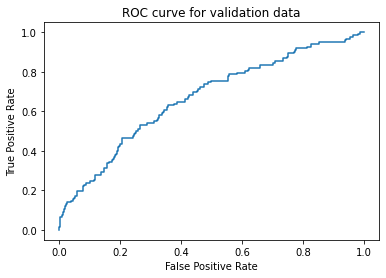

In [55]:
#define metrics
y_valid_pred_probs = clf.predict_proba(x_valid)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_valid,  y_valid_pred_probs)

#create ROC curve
plt.plot(fpr, tpr)
plt.title('ROC curve for validation data')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### d) Interpreting the ROC Curve (4 points)

Using the plot generated in Part (c), what is the False Positive Rate associated with correctly identifying 80% of patients at risk for death in the ICU? Why might a high false positive rate be appropriate in this setting? You can read the answer off the ROC curve plot.


With a true positive rate of 80% the associated false positive rate is ~50%. This is might be okay because it is a allows us to have a high true positive rate which saves more lives. The only thing wasted is time on patients that might not have died which is still okay.


### e) Modelling Doctors' Decision-Making (6 points)

For this part, produce a short report that answers all the questions below. Include code that produces the numbers that you need.

At the beginning of their shift, a doctor reviews their patients' charts, and decides what intervention is needed for each patient. In the following parts, we will be trying to improve this process. We will consider a simplified version of what is going on. Suppose that if the doctor intervenes correctly, the patient will not die; suppose that the doctor has 60 minutes to look through 25 patient charts; and suppose that the probability of missing the correct treatment if the doctor spends $t$ minutes on reviewing a file is

$$P(\textrm{fail}) = \exp(-t^2/100).$$


1. If the doctor reviews all the files, spends an equal amount of time on each chart, and there are 10 patients who will die without the correct intervention, how many patients are expected to die, if the doctor intervenes when they see that that's needed? What is the percentage of patients who are expected to die, out of 25?

2. Suppose now that the doctor is looking through all the patient charts in the validation set. They would have proportionately more time: $(N/25)\times 60$ minutes in total (where $N$ is the total number of patients in the set). How many patients would be expected to die, if the doctor intervenes correctly when they know they should do that?

3. Now, suppose that the doctor only reviews the files of patients for whom the model outputs a probability of greater than $20\%$. This would give the doctor more time to look through each file, but the doctor would never be able to intervene in the cases of patients form whom the output is $20\%$ or smaller. How many patients would be expected to die?



In [56]:
#Problem 1
import math

t = 60/25
P_fail = math.exp(-(t**2)/100)
print("# of deaths:", P_fail *10)
print("% death:", P_fail *10 / 25 *100, "%")


# of deaths: 9.440274829178357
% death: 37.76109931671343 %


In [57]:
#Problem 2
print("Size of Validation set:",len(x_valid))
N = len(x_valid)
t_total = N/25 *60
death = 0
for val in y_valid:
  if val == 1:
    death += 1

print("Actual # of deaths in Validation set:",death)
num_death = P_fail * death
print("# of deaths:", num_death)

Size of Validation set: 800
Actual # of deaths in Validation set: 122
# of deaths: 115.17135291597594


In [58]:
#Problem 3

p_pred = clf.predict_proba(x_valid) #get the prob of death for each patient in valid set
print(p_pred)
N = 0 # of patients to examine
index = 0 # match the actual patients in the set
death_over = 0 #deaths in group over 20% 
death_under = 0
for val in p_pred:
  if val[1] > .2: # the 20% threshold value
    if y_train[index] == 1: #this just means if the patient actually died
      death_over += 1
    N +=1
  else:
    if y_train[index] == 1:
      death_under += 1
  index += 1

print(N)
print(death_over)
print(death_under)
t = t_total / N
P_fail = math.exp((-(t**2))/100)
tot_death = (P_fail * death_over) + death_under
print("# of deaths",tot_death)

[[0.79874517 0.20125483]
 [0.87650854 0.12349146]
 [0.86410869 0.13589131]
 ...
 [0.93236977 0.06763023]
 [0.91873863 0.08126137]
 [0.80621639 0.19378361]]
136
26
95
# of deaths 98.54315280354231


1. 9.44 patients or 37.76% of patients are expected to die
2. 115.17 patients are expected to die
3. 98.54 patients are expected to die

### f) Modelling Doctors' Decision-Making - Revisited (7 points)


In this Part, you will explore the policy implications of using our model in an understaffed hospital. 

Suppose that we are considering a policy of only reviewing the files of patients whose probability of death is above a threshold `thr`. Each chart would be given an equal amount of time, and the total amount of time will be $(N/25)\times 60$.

Using the model from previous part, plot the total number of expected deaths under the policy vs. the threshold. Using the plot, what is the best threshold to use that would minimize the number of deaths?

You should compute the expected number of deaths for the thresholds `np.arange(0, 1, 0.01)`.

Use the validation set.




min # of deaths 96.24


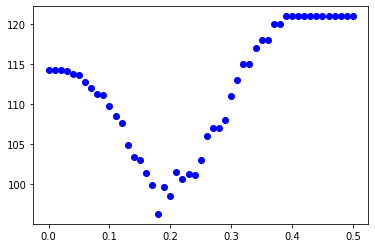

In [59]:
### YOUR CODE HERE ###
thr = np.arange(0, 1, 0.01)
p_pred = clf.predict_proba(x_valid)
thr_num_death = []
thr_plt = []
for prob in thr:
  N = 0 # of patients to examine
  index = 0
  death_over = 0 #deaths in group over 20% 
  death_under = 0
  for val in p_pred:
    if val[1] > prob:
      if y_train[index] == 1:
        death_over += 1
      N +=1
    else:
      if y_train[index] == 1:
        death_under += 1
    index += 1
  if(N > 0): # this just avoids cases which cause errors
    t = t_total / N
    P_fail = P_fail = math.exp((-(t**2))/100)
    tot_death = (P_fail * death_over) + death_under
    thr_num_death.append(tot_death) # y values
    thr_plt.append(prob) #x values
    #print(f'# of deaths: {tot_death:.2f}')

print(f'min # of deaths {min(thr_num_death):.2f}')
plt.plot(thr_plt, thr_num_death, 'bo')
plt.show()


The threshold for  the probability of death that has the lowest expected number of deaths is .18 or 18%

### g) Modelling Doctors' Decision-Making - Testing (7 points)

On the test set, compare the total number of expected deaths under the best policy that was selected in Part (f) to reviewing each patient's file. In relative terms (i.e., as a percentage), how many lives would be saved, if the assumptions underlying our simulation are accurate?

In [60]:
### YOUR CODE HERE ###
p_pred = clf.predict_proba(x_test)

N = 0 # of patients to examine
index = 0
death_over = 0 #deaths in group over 20% 
death_under = 0
for val in p_pred:
  if val[1] > .18:
    if y_test[index] == 1:
      death_over += 1
    N +=1
  else:
    if y_test[index] == 1:
      death_under += 1
  index += 1


t = t_total / N
P_fail = P_fail = math.exp((-(t**2))/100)
tot_death = (P_fail * death_over) + death_under
print("# of deaths",tot_death)

# of deaths 75.52215007428464


In [95]:
#actual number of deaths
defth = 0 #get actual number of deaths in test set
for val in y_test:
  if val == 1:
    defth += 1

print(defth)
print(f'% actual death in test set: {(defth/800*100):.2f}%')
print(f'% of death in test set with new simulation: {(75.52/800*100):.2f}%')
print(f'% of lives saved w/ new simulation: {(defth/800*100) - (75.52/800*100):.2f}%')

103
% actual death in test set: 12.88%
% of death in test set with new simulation: 9.44%
% of lives saved w/ new simulation: 3.44%


% actual death in test set: 12.88%

% of death in test set with new simulation: 9.44%

% of lives saved w/ new simulation: 3.44%


## Question 2 - Neural Networks
---

We will train a fully connected neural networks to recognize face images of cats and dogs. 

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

In [63]:
data_dir = 'pets'
image_width = 32
image_height = 32
batch_size = 10

### a) Load the Pets Dataset (2 points)
There are 110 images of size $32\times32$. Run the following code block to import the data. Keep in mind that they will be downloaded from the internet, so it may take a while.

In [64]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [65]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [66]:
# Download the data
downloaded = drive.CreateFile({'id':"1NXiYkupBcolg90e6wE_Nm_F9VTFoXIja"})
downloaded.GetContentFile('pets.npy')  
data = np.load("pets.npy",allow_pickle=True)

In [67]:
# Create X and y
X, y = (data[()]['X'], data[()]['y'])
print(X)
print(y)

[[[ 45  59  38 ...  80  68  65]
  [ 23  39  42 ...  78  82  73]
  [ 17  24  37 ...  84  81  57]
  ...
  [ 64  62  62 ...  50  59  62]
  [ 61  61  60 ...  52  54  57]
  [ 59  60  61 ...  54  52  57]]

 [[ 99 109 119 ... 124 114 105]
  [104 113 130 ... 110 102 112]
  [101 115 127 ... 102 102  94]
  ...
  [198 187 184 ...  96  90 100]
  [204 196 185 ... 109 110 111]
  [211 205 195 ... 124 114 118]]

 [[160 161 173 ... 121 123 102]
  [152 146 148 ... 116 102  84]
  [157 142 130 ...  75  70  71]
  ...
  [222 230 211 ...  54  47  60]
  [231 208 223 ...  71  54  44]
  [214 200 235 ...  47  73  61]]

 ...

 [[ 85 104 124 ... 105 103  85]
  [ 83 103 125 ... 105 104  86]
  [ 82 105 126 ...  75 112  88]
  ...
  [ 89 109 134 ...  37  38  37]
  [ 90 110 134 ...  36  44  34]
  [ 90 116 137 ...  26  29  27]]

 [[105 104 106 ... 169 172 175]
  [ 95  93  98 ... 176 175 174]
  [ 98 100 114 ... 160 166 171]
  ...
  [132 145 140 ... 142 112 116]
  [148 153 153 ... 124 105 106]
  [130 128 133 ... 137 115 1

In [68]:
# Get class names and create ID
class_names = ['cat', 'dog']
class_dict = {i:class_name for i,class_name in enumerate(class_names)}

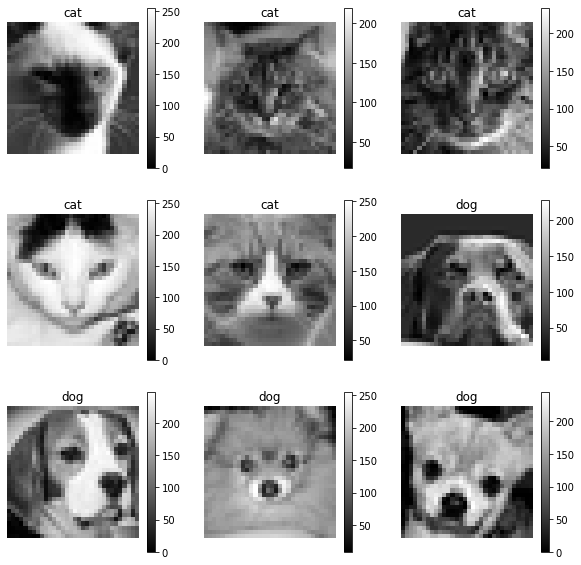

In [69]:
# Plot some images
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for count, i in enumerate(range(0,110, 13)):
    ax = plt.subplot(3, 3, count + 1)
    plt.imshow(X[i],cmap='gray')
    plt.colorbar()
    plt.title(class_names[y[i]])
    plt.axis("off")

Answer the following questions:

1.) What are the data types for X and y?

2.) What are the shapes of X and y?

3.) What is the minimum and maximum value of X?

1.) X 2d array that is the numerical representation of the images on the gray scale. Y is a simple binary. It is for the actual identities of the images where 0 means that the image is a cat and 1 means its a dog

2.) The shape of X is (110, 32, 32). The shape of Y is (110, 1)

3.) The min value of X is 0 and the max is 255


### b) Data Preprocessing (3 points)
As you can see above, the pixel values are in the [0,255]. This is the normal range for images. Recall from the previous lectures and excercises that we need to normalize our data.

In order to normalize our data to [0,1] we use the equation:

$$x_{norm}=\frac{x-x_{min}}{x_{max}-x_{min}}$$

In our case we can assume that $x_{min}=0$ and $x_{max}=255$, this is a safe assumption since we are working with image data.

This means that for image data, if we want to normlize to [0,1] the equation simplifies to:

$$img_{norm}=\frac{img}{255}$$

Anytime you work with image data in any kind of model you will be normalizing with this equation. Unless the range you want to normalize is different. Sometimes you want to normalize between [-1,1], for that you would use a slightly different equation.


Normalize the X data using the above equation and save as train_images.

In [70]:
train_images = X / 255
print(X.shape)
y.shape

(110, 32, 32)


(110,)

If we show the image agian, you will see the values are all scaled correctly.

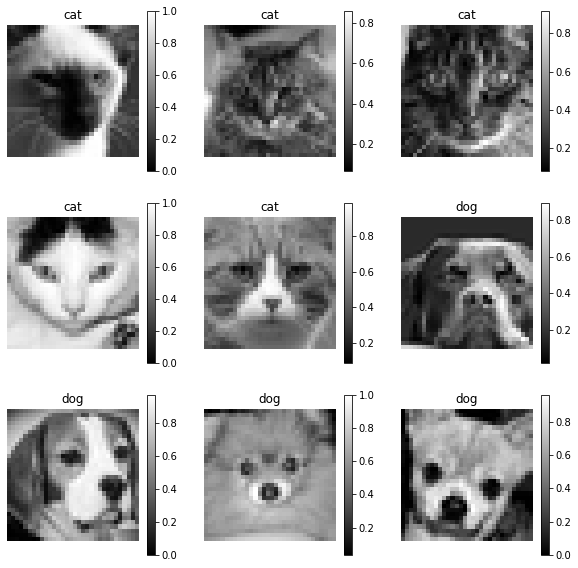

In [71]:
# Plot images
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for count, i in enumerate(range(0,110, 13)):
    ax = plt.subplot(3, 3, count + 1)
    plt.imshow(train_images[i],cmap='gray')
    plt.colorbar()
    plt.title(class_names[y[i]])
    plt.axis("off")

In [72]:
print(np.min(train_images))
print(np.max(train_images))

0.0
1.0


What is the new minimum and maximum value of X?

Min: 0.0

Max: 1.0

### c) Reshaping the Data (5 points)

Please reshpe training images to be 1024-dim (from $32 \times 32$). 

Hint: look into numpy.reshape().


In [73]:
print(f'Before reshape, train_images shape: {train_images.shape}')

train_images = train_images.reshape([110, -1])

print(f'Before reshape, train_images shape: {train_images.shape}')

Before reshape, train_images shape: (110, 32, 32)
Before reshape, train_images shape: (110, 1024)


### d) Building a Simple Neural Network (15 points)
In the cell below, build a fully-connected feed-forward neural network with the following layers:
* **input layer** of shape 1024
* **hidden layer** with 25 neurons, and relu activation
* **output layer** with 1 neuron, and sigmoid activation

In [74]:
from tensorflow.keras.layers import Input, Dense 
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import *
from tensorflow.keras.optimizers import SGD

# Build neural network
def build_model1(): 
  model = Sequential() 
  model.add(Dense(units = 25,input_dim=1024, activation='relu')) 
  model.add(Dense(units = 1, activation='sigmoid')) 
  return model

model = build_model1()

In [75]:
# Show a summary of your model
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 25)                25625     
                                                                 
 dense_8 (Dense)             (None, 1)                 26        
                                                                 
Total params: 25,651
Trainable params: 25,651
Non-trainable params: 0
_________________________________________________________________


Declare the optimizer using Stochastic Gradient Descient with learning rate of 0.001, weight decay of 1e-6 and momentum of 0.009. Compile your model using the 'binary_crossentropy' loss function and 'accuracy' as the metrics.

In [76]:
# Declare optimizer
optimizer =  SGD(lr=0.001, decay=1e-6, momentum=0.009) #Stochastic Gradient Descient

# Compile model
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Now we will train our model to learn pet faces using train_images and the 'y' labels. Our dataset is small so we will use 10% of the data as test set data. Train your model using the following parameters:

Fit your model using the train_images, 'y' labels, a batchsize of 10, and validation split of 0.1. Train for 500 epochs.

.fit documentation: https://www.tensorflow.org/api_docs/python/tf/keras/Model

In [77]:
# Call fit on your model passing in the X, y data above, train for 500 epochs
y = y.reshape(-1,1)


hist =  model.fit(train_images,
                    y, 
                    epochs=500, 
                    batch_size=10, 
                    validation_split=0.1)

Epoch 1/500
10/10 [==============================] - 1s 42ms/step - loss: 0.7384 - accuracy: 0.4444 - val_loss: 0.5969 - val_accuracy: 0.9091
Epoch 2/500
10/10 [==============================] - 0s 10ms/step - loss: 0.7152 - accuracy: 0.4545 - val_loss: 0.6503 - val_accuracy: 0.8182
Epoch 3/500
10/10 [==============================] - 0s 11ms/step - loss: 0.7037 - accuracy: 0.5354 - val_loss: 0.6874 - val_accuracy: 0.7273
Epoch 4/500
10/10 [==============================] - 0s 10ms/step - loss: 0.6953 - accuracy: 0.5152 - val_loss: 0.7116 - val_accuracy: 0.5455
Epoch 5/500
10/10 [==============================] - 0s 8ms/step - loss: 0.6892 - accuracy: 0.5657 - val_loss: 0.7311 - val_accuracy: 0.4545
Epoch 6/500
10/10 [==============================] - 0s 14ms/step - loss: 0.6857 - accuracy: 0.5758 - val_loss: 0.7429 - val_accuracy: 0.3636
Epoch 7/500
10/10 [==============================] - 0s 9ms/step - loss: 0.6803 - accuracy: 0.5859 - val_loss: 0.7539 - val_accuracy: 0.2727
Epoch 8/

In [78]:
def plot_losses(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()
def plot_accuracies(hist):
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()

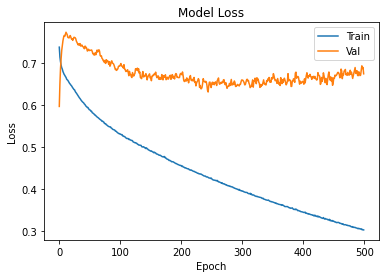

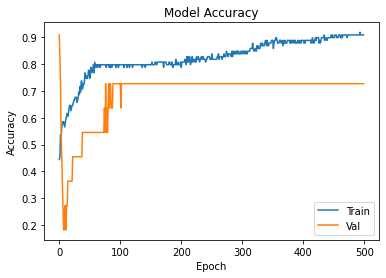

In [79]:
# plot your losses and accuracies
plot_losses(hist)
plot_accuracies(hist)

For the input size, this one hidden layer neural network is probably too small. However, we can see that the model attempts to minimize the overall loss. Summarize your observations on the model's learning curves, model's overall classification accuracy on the validation set, and the least amount of loss on validation set?

At first the model does not do a good job at classifying the images in either sets. However as the number of epochs exceed 100 it gradually reaches a maximum accuracy of .9 for training and .7 for the validation set. The loss also just balances out. There is a divergence between training and val loss as the validation loss stays steady around .6-.7 while the training loss goes below .4

### e) Building a Second Neural Network (15 points)
Next, you will build a neural network with one hidden layer that is wider than the previous model's hidden layer. In the cell below, build a neural network with the following layers:
* **input layer** of shape 1024
* **hidden layer** with 100 neurons, and relu activation
* **output layer** with 1 neuron, and sigmoid activation

In [80]:
# Build Neural network
def build_model2(): 
  model = Sequential() 
  model.add(Dense(units = 100,input_dim=1024, activation='relu')) 
  model.add(Dense(units = 1, activation='sigmoid')) 
  return model

model = build_model2()

In [81]:
# Show a summary of your model
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 100)               102500    
                                                                 
 dense_10 (Dense)            (None, 1)                 101       
                                                                 
Total params: 102,601
Trainable params: 102,601
Non-trainable params: 0
_________________________________________________________________


Again, declare the optimizer using Stochastic Gradient Descient with learning rate of 0.001, weight decay of 1e-6 and momentum of 0.009. Compile your model using 'binary_crossentropy' loss function and 'accuracy' as the metrics.

In [82]:
# Declare optimizer
optimizer =  SGD(lr=0.001, decay=1e-6, momentum=0.009)

# Compile model
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In this cell fit your model using the train images, y labels, a batchsize of 10, and validation split of 0.1. Train for 500 epochs.

In [83]:
y = y.reshape(-1,1)

# Call fit on your model passing in the X, y data above, train for 500 epochs
hist =  model.fit(train_images,
                    y, 
                    epochs=500, 
                    batch_size=10, 
                    validation_split=0.1)

Epoch 1/500
10/10 [==============================] - 1s 22ms/step - loss: 0.8180 - accuracy: 0.4444 - val_loss: 0.4753 - val_accuracy: 0.9091
Epoch 2/500
10/10 [==============================] - 0s 6ms/step - loss: 0.7136 - accuracy: 0.5051 - val_loss: 0.5921 - val_accuracy: 0.8182
Epoch 3/500
10/10 [==============================] - 0s 6ms/step - loss: 0.6691 - accuracy: 0.5152 - val_loss: 0.6782 - val_accuracy: 0.7273
Epoch 4/500
10/10 [==============================] - 0s 5ms/step - loss: 0.6456 - accuracy: 0.6566 - val_loss: 0.7376 - val_accuracy: 0.5455
Epoch 5/500
10/10 [==============================] - 0s 5ms/step - loss: 0.6329 - accuracy: 0.7374 - val_loss: 0.7673 - val_accuracy: 0.4545
Epoch 6/500
10/10 [==============================] - 0s 6ms/step - loss: 0.6273 - accuracy: 0.7374 - val_loss: 0.7898 - val_accuracy: 0.3636
Epoch 7/500
10/10 [==============================] - 0s 6ms/step - loss: 0.6204 - accuracy: 0.7374 - val_loss: 0.8088 - val_accuracy: 0.1818
Epoch 8/500


In [84]:
def plot_losses(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()
def plot_accuracies(hist):
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()

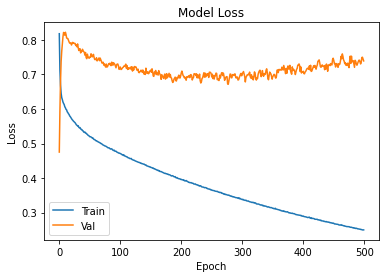

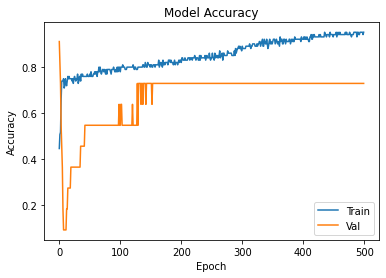

In [85]:
# Plot your losses and accuracies
plot_losses(hist)
plot_accuracies(hist)

Next, summarize this models results. Consider the following questions when answering. Remember that this model has a higher learning capacity than the previous model. 

1) How did this model compare to previous model? 

2) Did it outperform the previous models? 

3) What was your model's overall classification accuracy on the validation set and the least amount of loss on validation set? 

1. In terms of validation accuracy the max accuracy was around the same as the previous model, and after training the accuracy converges to ~.7 which is about the same as the first model. The gradual increase in validation set loss as the training goes on suggests that there is a slight amount of overfitting.
2. In the end this model did not perform better then the first model. It performed about the same
3. At the end of the training the overall accuracy on the validation set was ~.7. and minimum loss on the val set was also ~.8

### f) Building a Third Neural Network (15 points)
Lastly, you will build a fully-connected neural network with two hidden layers. In the cell below, build a neural network with the following layers:
* **input layer** of shape 1024
* **hidden layer** with 100 neurons, and relu activation
* **hidden layer** with 25 neurons, and relu activation
* **output layer** with 1 neuron, and sigmoid activation

In [86]:
from tensorflow.keras.layers import Input, Dense # only use these layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import * # you can use any optimizer

# Build Neural network
def build_model3(): 
  model = Sequential() 
  model.add(Dense(units = 100,input_dim=1024, activation='relu')) 
  model.add(Dense(units = 25, activation='relu')) 
  model.add(Dense(units = 1, activation='sigmoid')) 
  return model

model = build_model3()

In [87]:
# Show a summary of your model
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 100)               102500    
                                                                 
 dense_12 (Dense)            (None, 25)                2525      
                                                                 
 dense_13 (Dense)            (None, 1)                 26        
                                                                 
Total params: 105,051
Trainable params: 105,051
Non-trainable params: 0
_________________________________________________________________


Since this model is bigger than the previous models, we will use a more powerful optimizer. Declare the optimizer as Adam with learning rate of 0.001. Compile your model using 'binary_crossentropy' loss function and 'accuracy' as the metrics.

In [88]:
# Declare optimizer
optimizer =  Adam(lr=0.001)

# Compile model
# YOUR CODE HERE
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In this sell fit your model using the train images, y labels, a batchsize of 10, and validation split of 0.1. Train for 500 epochs.

In [89]:
y = y.reshape(-1,1)

# Call fit on your model passing in the X, y. 
# Train for 500 epochs with a batch size of 10 and validation split of 0.1
hist =  model.fit(train_images,
                    y, 
                    epochs=500, 
                    batch_size=10, 
                    validation_split=0.1)

Epoch 1/500
10/10 [==============================] - 1s 24ms/step - loss: 0.6737 - accuracy: 0.6061 - val_loss: 1.0155 - val_accuracy: 0.0000e+00
Epoch 2/500
10/10 [==============================] - 0s 5ms/step - loss: 0.5894 - accuracy: 0.6465 - val_loss: 0.8046 - val_accuracy: 0.5455
Epoch 3/500
10/10 [==============================] - 0s 8ms/step - loss: 0.5381 - accuracy: 0.7374 - val_loss: 0.4415 - val_accuracy: 0.8182
Epoch 4/500
10/10 [==============================] - 0s 5ms/step - loss: 0.4860 - accuracy: 0.7677 - val_loss: 0.7863 - val_accuracy: 0.5455
Epoch 5/500
10/10 [==============================] - 0s 5ms/step - loss: 0.5338 - accuracy: 0.6970 - val_loss: 0.2984 - val_accuracy: 0.9091
Epoch 6/500
10/10 [==============================] - 0s 6ms/step - loss: 0.4383 - accuracy: 0.7879 - val_loss: 0.5732 - val_accuracy: 0.7273
Epoch 7/500
10/10 [==============================] - 0s 6ms/step - loss: 0.3921 - accuracy: 0.8283 - val_loss: 1.2367 - val_accuracy: 0.2727
Epoch 8/

In [90]:
def plot_losses(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()
def plot_accuracies(hist):
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'])
    plt.show()

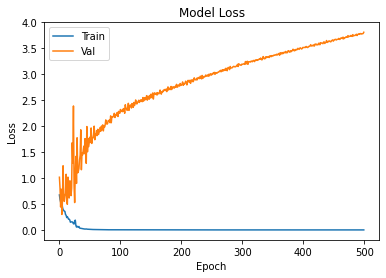

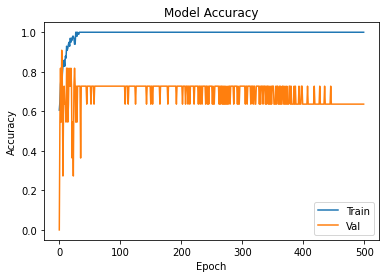

In [91]:
# plot your losses and accuracies
plot_losses(hist)
plot_accuracies(hist)

Summarize this model's results. Consider the following when answering:

1) How did this model compare to previous models? 

2) Did it outperform the previous models? 

3) What was your model's overall classification accuracy on the validation set and the least amount of loss on validation set? 

4) Adam is a powerful optimizer, and may quickly converge to an a minima. Did this happen with this model?

1) This model was very fast to find the minima of the training data. In less than 100 epochs. However when it comes to performing on the validation data that is not the case. It in fact could not very accurately predict the images. Not much better then just guessing at ~.6. This suggests serious overfitting.

2) No the model that performed best was the second model with validation set accuaracy of about 70%

3) What was your model's overall classification accuracy on the validation set and the least amount of loss on validation set?

all three models were roughly in the range of 50-70% for accuaracy on the validation set. As for the loss of the first two models it was around .7 loss and for the third model it was roughly 5

4) Yes. However it came at a cost. As there was major overfitting of the training data as shown by the divergence of the val and training loss